In [1]:
import pandas as pd
import os
from utils.ml_utils import BoostingEmissionsPredictionPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SCRIPT_DIR_PATH = os.getcwd()
ROOT_DIR_PATH = os.path.dirname(SCRIPT_DIR_PATH)
DATA_DIR_PATH = os.path.join(ROOT_DIR_PATH, "data")
MAPPING_DIR_PATH = os.path.join(DATA_DIR_PATH, "mapping")
PREDICTORS_DIR_PATH = os.path.join(DATA_DIR_PATH, "predictors")
SSP_DIR_PATH = os.path.join(DATA_DIR_PATH, "ssp")
SIMULATION_DIR_PATH = os.path.join(SSP_DIR_PATH, "sisepuede_run_2025-01-14T17;04;06.975301_output_database")
TRAINING_DIR_PATH = os.path.join(DATA_DIR_PATH, "training")

In [4]:
TRAINING_DATA_PATH = os.path.join(TRAINING_DIR_PATH, "training_data.csv")
training_df = pd.read_csv(TRAINING_DATA_PATH)
training_df = training_df.drop(columns=["primary_id", "future_id"])
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431


In [5]:
# Set some parameters
use_pca = False

## EDA

In [6]:
training_df["total_emissions_last_five_years"].describe()

count    1.000000e+03
mean     7.690960e+05
std      1.071674e+07
min      3.616263e+02
25%      6.362033e+02
50%      7.210529e+02
75%      7.955229e+02
max      2.268719e+08
Name: total_emissions_last_five_years, dtype: float64

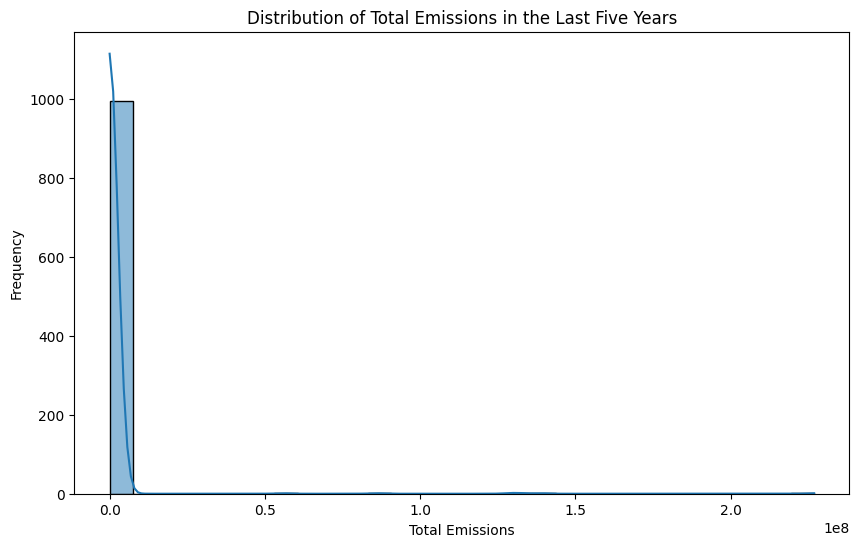

In [7]:
def plot_emissions_histogram(df, column="total_emissions_last_five_years", bins=30, kde=True, title="Distribution of Total Emissions in the Last Five Years"):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel("Total Emissions")
    plt.ylabel("Frequency")
    plt.show()

plot_emissions_histogram(training_df)


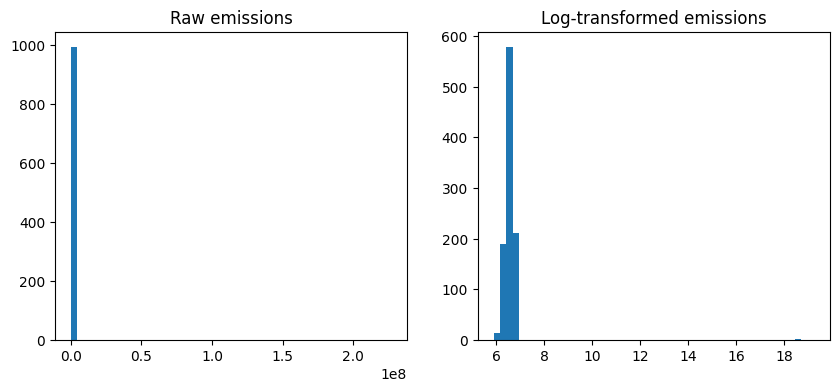

In [8]:
y = training_df['total_emissions_last_five_years']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y, bins=50)
ax[0].set_title("Raw emissions")
ax[1].hist(np.log1p(y), bins=50)
ax[1].set_title("Log-transformed emissions")
plt.show()


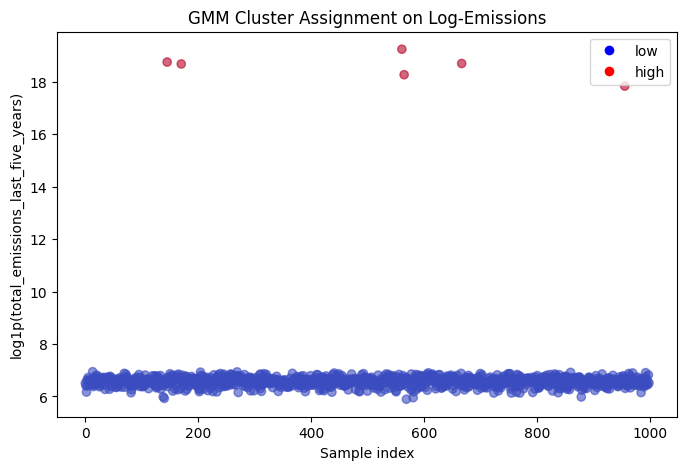

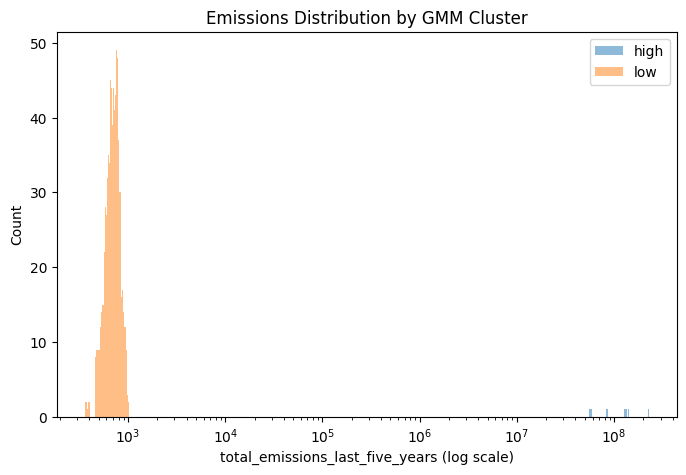

In [9]:
from sklearn.mixture import GaussianMixture

# 1. Fit GMM on log1p(target)
y = training_df['total_emissions_last_five_years']
log_y = np.log1p(y).values.reshape(-1,1)

gm = GaussianMixture(n_components=2, random_state=0)
labels = gm.fit_predict(log_y)

# 2. Map labels to “low” vs “high” based on cluster means
means = gm.means_.flatten()
low_lab, high_lab = np.argsort(means)
label_map = {low_lab: 'low', high_lab: 'high'}

training_df['cluster'] = labels
training_df['cluster_name'] = training_df['cluster'].map(label_map)

# 3. Scatter plot of log-emissions colored by cluster
plt.figure(figsize=(8,5))
plt.scatter(training_df.index, log_y.flatten(),
            c=training_df['cluster'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Sample index')
plt.ylabel('log1p(total_emissions_last_five_years)')
plt.title('GMM Cluster Assignment on Log-Emissions')
plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='w', label='low',  markerfacecolor='blue', markersize=8),
    plt.Line2D([], [], marker='o', color='w', label='high', markerfacecolor='red',  markersize=8)
])
plt.show()

# 4. (Optional) Overlaid histograms on original scale
plt.figure(figsize=(8,5))
for name, grp in training_df.groupby('cluster_name'):
    plt.hist(grp['total_emissions_last_five_years'],
             bins=50, alpha=0.5, label=name)
plt.xscale('log')
plt.xlabel('total_emissions_last_five_years (log scale)')
plt.ylabel('Count')
plt.title('Emissions Distribution by GMM Cluster')
plt.legend()
plt.show()


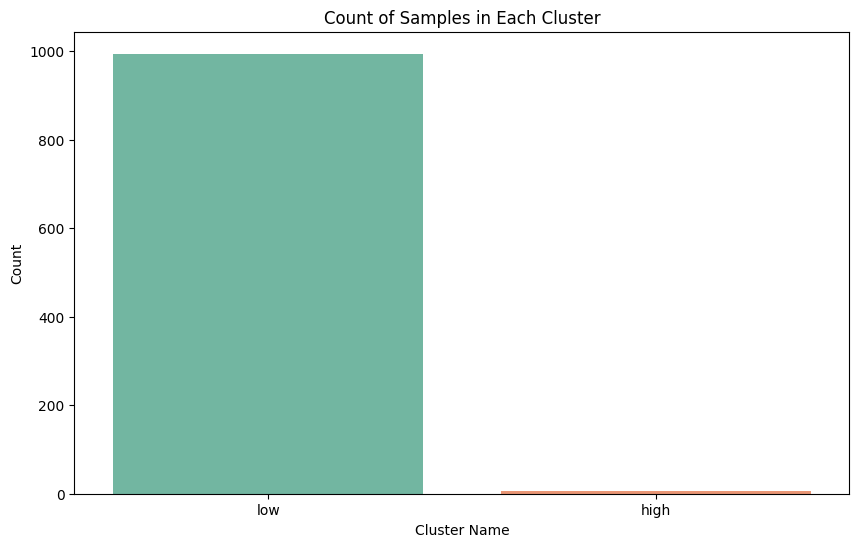

In [10]:
# plot bar graph of the two categories of cluster name
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df, x='cluster_name', palette='Set2', hue="cluster_name")
plt.title("Count of Samples in Each Cluster")
plt.xlabel("Cluster Name")
plt.ylabel("Count")
plt.show()

## Data Cleaning

In [11]:
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years,cluster,cluster_name
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643,0,low
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538,0,low
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631,0,low
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335,0,low
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431,0,low


In [12]:
# remove cluster == 1
training_df = training_df[training_df['cluster'] == 0]
training_df = training_df.drop(columns=['cluster', 'cluster_name'])
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431


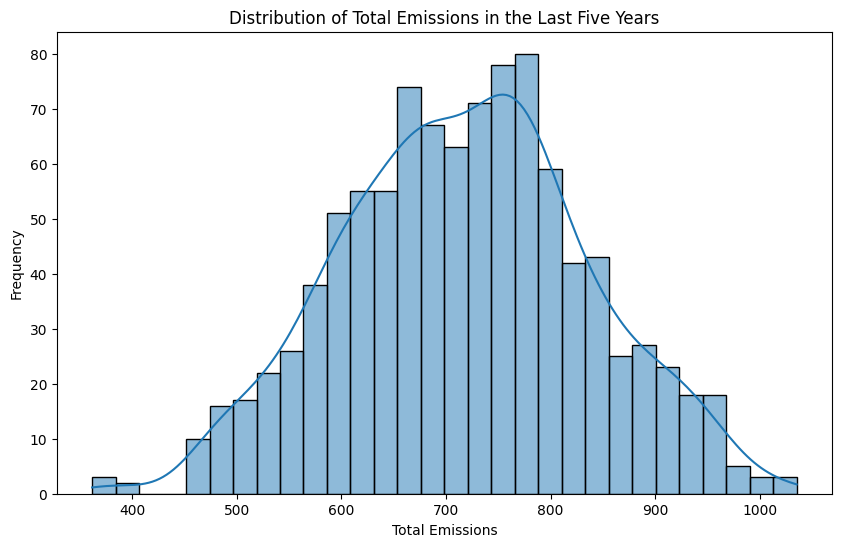

In [13]:
plot_emissions_histogram(training_df)

In [14]:
training_df["total_emissions_last_five_years"].describe()

count     994.000000
mean      717.252770
std       117.737676
min       361.626320
25%       635.400195
50%       719.714422
75%       794.299010
max      1035.283867
Name: total_emissions_last_five_years, dtype: float64

## EDA Again

In [15]:
# Correlation with target
corr = training_df.corr()["total_emissions_last_five_years"].sort_values(ascending=False)
print("Top 10 Correlated Features:\n", corr.head(11))


Top 10 Correlated Features:
 total_emissions_last_five_years    1.000000
44                                 0.062801
262                                0.062671
27                                 0.055023
1384                               0.054130
24                                 0.051682
1464                               0.045807
22                                 0.044632
1466                               0.043101
2                                  0.042732
31                                 0.041644
Name: total_emissions_last_five_years, dtype: float64


In [16]:
from sklearn.feature_selection import VarianceThreshold

def plot_all_histograms(df: pd.DataFrame,
                        bins: int = 30,
                        max_cols: int = 4,
                        figsize_per_plot: tuple = (4,3)):
    """
    Plot histograms for every column in df, arranged in a grid.
    
    Parameters
    ----------
    df : DataFrame of numeric features
    bins : number of bins per histogram
    max_cols : number of subplots per row
    figsize_per_plot : (width, height) of each subplot
    """
    n_features = len(df.columns)
    n_rows = int(np.ceil(n_features / max_cols))
    fig, axes = plt.subplots(n_rows, max_cols,
                             figsize=(figsize_per_plot[0]*max_cols,
                                      figsize_per_plot[1]*n_rows))
    axes = axes.flatten()
    for ax, col in zip(axes, df.columns):
        ax.hist(df[col].dropna(), bins=bins, edgecolor='black')
        ax.set_title(col)
    # turn off any unused axes
    for ax in axes[n_features:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()


def find_constant_columns(df: pd.DataFrame) -> list:
    """
    Return list of columns with zero variance.
    """
    selector = VarianceThreshold(threshold=0.0)
    selector.fit(df)
    constant_mask = ~selector.get_support()
    return list(df.columns[constant_mask])


def find_near_constant_columns(df: pd.DataFrame,
                               threshold: float = 0.01) -> list:
    """
    Return list of columns whose variance is <= threshold.
    
    Parameters
    ----------
    threshold : float
        Any column with var <= threshold is considered near-constant.
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    near_constant_mask = ~selector.get_support()
    return list(df.columns[near_constant_mask])


def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a summary table with common univariate stats:
      mean, std, skew, kurtosis, min, 25%, 50%, 75%, max, missing%
    """
    desc = df.describe().T
    desc['skew']     = df.skew()
    desc['kurtosis'] = df.kurtosis()
    desc['missing_pct'] = df.isna().mean() * 100
    return desc[['mean','std','skew','kurtosis',
                 'min','25%','50%','75%','max','missing_pct']]


def find_outlier_columns(df: pd.DataFrame,
                         z_thresh: float = 3.0) -> dict:
    """
    Identify columns with extreme outliers via z-score.
    Returns a dict mapping column -> % of rows with |z| > z_thresh.
    """
    from scipy.stats import zscore
    zs = df.apply(zscore).abs()
    outlier_pct = (zs > z_thresh).sum() / len(df) * 100
    return outlier_pct[outlier_pct>0].to_dict()


In [17]:
num_df = training_df.select_dtypes(include='number')

# 1. Quick summary table
summary = numeric_summary(num_df)
summary

,mean,std,skew,kurtosis,min,25%,50%,75%,max,missing_pct
1,0.501091,0.288910,-0.005023,-1.200976,0.000850,0.250515,0.501630,0.750824,0.999629,0.0
2,0.499849,0.289438,0.000111,-1.206653,0.000067,0.248378,0.500581,0.750709,0.999220,0.0
3,0.500063,0.289140,0.000292,-1.201563,0.000571,0.250064,0.500255,0.750267,0.999263,0.0
4,0.500061,0.289198,0.001491,-1.202841,0.000150,0.249366,0.499114,0.751627,0.999253,0.0
5,0.500113,0.289311,-0.000236,-1.203766,0.000513,0.249692,0.498794,0.751372,0.999054,0.0
...,...,...,...,...,...,...,...,...,...,...
1477,0.500280,0.288231,-0.003250,-1.197665,0.000911,0.250641,0.501309,0.749502,0.999552,0.0
1478,0.500244,0.289087,-0.000183,-1.204084,0.000298,0.249931,0.499961,0.750580,0.999187,0.0
1480,0.499250,0.288787,0.005784,-1.199181,0.000940,0.249368,0.498266,0.749609,0.999603,0.0
1481,0.500458,0.289497,-0.004057,-1.206488,0.000978,0.248455,0.500780,0.751598,0.999622,0.0


In [18]:
# 2. Find constant / near-constant cols
const_cols      = find_constant_columns(num_df)
near_const_cols = find_near_constant_columns(num_df, threshold=1e-2)
print("Constant:", const_cols)
print("Near-constant:", near_const_cols)

Constant: []
Near-constant: []


In [19]:
# 3. Outlier inspection
outliers = find_outlier_columns(num_df, z_thresh=3.0)
print("Outlier percentages:", outliers)

Outlier percentages: {'total_emissions_last_five_years': 0.1006036217303823}


In [20]:
# 4. Plot all histograms (will show a big grid of 80 plots)
# plot_all_histograms(num_df, bins=30, max_cols=5, figsize_per_plot=(3,2))

In [21]:
from scipy.stats import zscore

# Remove outliers from total_emissions_last_five_years
outlier_mask = np.abs(zscore(num_df['total_emissions_last_five_years'])) > 3.0
training_df = training_df[~outlier_mask]
# Recompute the summary after removing outliers
num_df = training_df.select_dtypes(include='number')
outliers = find_outlier_columns(num_df, z_thresh=3.0)
print("Outlier percentages:", outliers)

Outlier percentages: {}


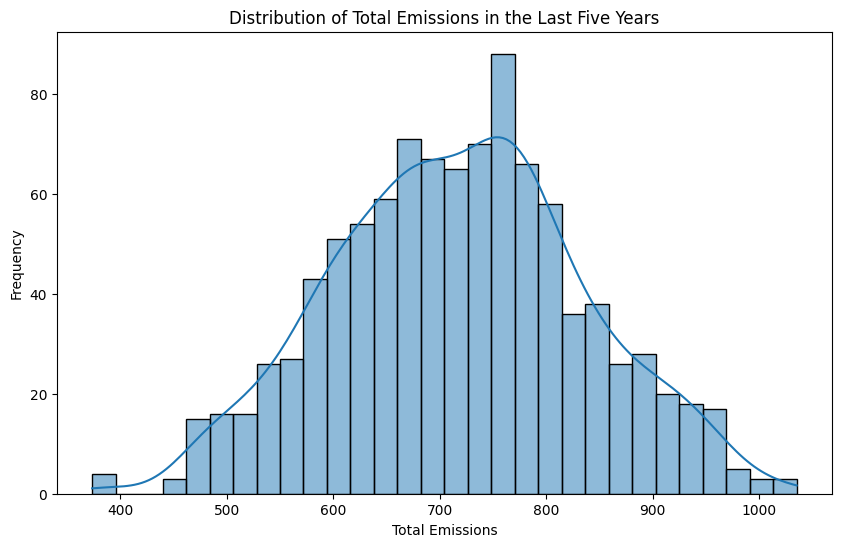

In [22]:
plot_emissions_histogram(training_df)

In [23]:
# from ydata_profiling import ProfileReport


# profile = ProfileReport(training_df, title="Profiling Report")
# profile.to_notebook_iframe()

## Preprocessing

In [24]:
def drop_highly_correlated(df, thresh=0.9, drop=True):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    if drop:
        print(f"Dropping {len(to_drop)} columns with correlation > {thresh}: {to_drop}")
    else:
        print(f"Columns with correlation > {thresh}: {to_drop}")
        return None


    return df.drop(columns=to_drop), to_drop

drop_highly_correlated(training_df, thresh=0.9, drop=False)

Columns with correlation > 0.9: []


In [25]:
from sklearn.decomposition import PCA

def pca_reduce(df, var_threshold=0.95):
    pca = PCA(n_components=var_threshold)
    Xp = pca.fit_transform(df)
    return pd.DataFrame(Xp,
                        columns=[f"PC{i+1}" for i in range(Xp.shape[1])],
                        index=df.index), pca

if use_pca:
    print("Reducing features using PCA...")
    pca_df, pca = pca_reduce(training_df.drop(columns="total_emissions_last_five_years"), var_threshold=0.95)
    print(f"Reduced to {pca_df.shape[1]} components explaining {pca.explained_variance_ratio_.sum():.2f} variance.")
    training_df = pd.concat([pca_df, training_df['total_emissions_last_five_years']], axis=1)

training_df.head()



,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431


## ML

In [26]:
#TODO: OPEN THE CLASS HERE
epp = BoostingEmissionsPredictionPipeline(training_df, target="total_emissions_last_five_years", test_size=0.2, random_state=42,)

In [27]:
epp.df

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.686931,0.293175,0.530016,0.537532,0.547453,0.592252,0.145215,0.595690,0.226719,0.555106,...,0.166374,0.492576,0.852423,0.576864,0.581870,0.729968,0.670905,0.526597,0.538860,623.338641
996,0.652014,0.614792,0.722367,0.728350,0.258821,0.451143,0.933635,0.699838,0.318238,0.118908,...,0.081739,0.427041,0.841771,0.700368,0.034557,0.110096,0.358843,0.228176,0.567834,747.358673
997,0.194568,0.471448,0.336939,0.843803,0.291440,0.503017,0.002373,0.607189,0.445903,0.462059,...,0.483941,0.270658,0.453539,0.533885,0.448723,0.985748,0.874981,0.341813,0.518431,634.154137
998,0.298093,0.985266,0.876711,0.357384,0.324181,0.318030,0.521157,0.057600,0.803029,0.038362,...,0.826473,0.188016,0.836447,0.053303,0.036249,0.291268,0.829999,0.494574,0.087424,915.717778


In [28]:
# epp.df.info()

Train/test split done!
Doing hyperparameter tunning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best hyperparameters: {'subsample': 0.5, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 30, 'max_features': 0.5, 'max_depth': 5, 'loss': 'absolute_error', 'learning_rate': 0.005}
Train model...
Evaluating model...
MAE:  85.9139
RMSE: 105.7747
R²:   0.0283


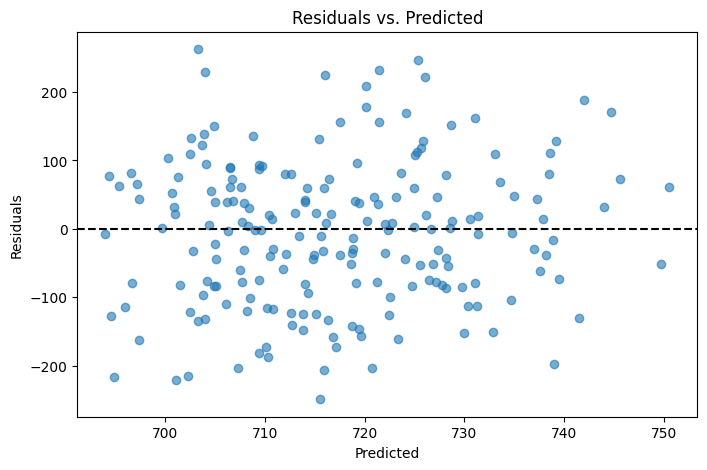

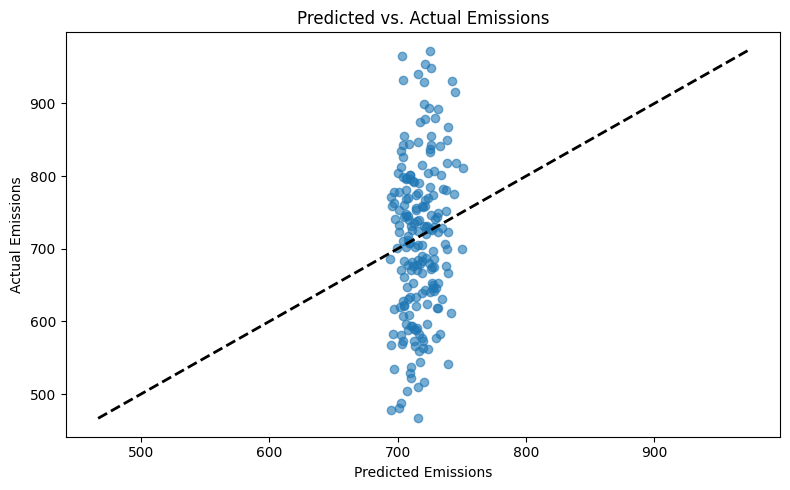

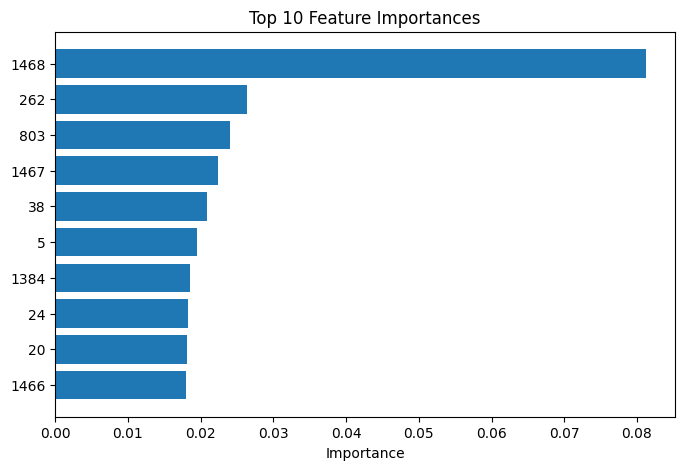

In [ ]:
epp.run(tune=True, log_transform=False, feature_select=True)